In [1]:
# Import dependencies
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)

In [2]:
# Read the data into a Pandas DataFrame
df = pd.read_csv('resources/play_by_play_2024_cleaned.csv')
df.head()

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,1,2024_01_ARI_BUF,NaN,NaN,NaN,NaN,NaN,BUF 35,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Touchdown,NaN,NaN,0.000000
1,40,2024_01_ARI_BUF,ARI,BUF,BUF,35.0,NaN,BUF 35,0,kickoff,...,0.0,0.0,0.0,NaN,NaN,NaN,Touchdown,7:13,TOUCHDOWN,0.257819
2,61,2024_01_ARI_BUF,ARI,BUF,ARI,70.0,1.0,ARI 30,10,run,...,0.0,0.0,0.0,NaN,NaN,3.0,Touchdown,7:13,TOUCHDOWN,-0.200602
3,83,2024_01_ARI_BUF,ARI,BUF,ARI,67.0,2.0,ARI 33,7,pass,...,0.0,0.0,0.0,22.0,22.0,NaN,Touchdown,7:13,TOUCHDOWN,2.028874
4,108,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,9.0,NaN,Touchdown,7:13,TOUCHDOWN,0.754242


### Question #1
---
**Ruby Bhatia**
- How do teams perform offensively and defensively in NFL Week 1 games?


### Question #2
----
**Nathan Roller**
- What are tendencies for teams in specific down and distance situations? 


In [3]:
# Import dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [4]:
# Display list of columns
df.columns

Index(['play_id', 'game_id', 'posteam', 'defteam', 'side_of_field',
       'yardline_100', 'down', 'yrdln', 'ydstogo', 'play_type', 'yards_gained',
       'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
       'run_location', 'run_gap', 'defteam_score', 'score_differential',
       'posteam_score_post', 'defteam_score_post', 'score_differential_post',
       'epa', 'wp', 'def_wp', 'home_wp', 'away_wp', 'fumble_forced',
       'fumble_out_of_bounds', 'safety', 'penalty', 'tackled_for_loss',
       'fumble_lost', 'touchdown', 'pass_touchdown', 'rush_touchdown',
       'return_touchdown', 'field_goal_attempt', 'fumble', 'passing_yards',
       'receiving_yards', 'rushing_yards', 'fixed_drive_result',
       'drive_time_of_possession', 'drive_end_transition', 'qb_epa'],
      dtype='object')

In [5]:
# Filter only the run and pass plays (removing other plays which are not designed to achieve a first down)
df_filtered = df[df['play_type'].isin(['run', 'pass'])].reset_index(drop=True)
df_filtered

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,61,2024_01_ARI_BUF,ARI,BUF,ARI,70.0,1.0,ARI 30,10,run,...,0.0,0.0,0.0,NaN,NaN,3.0,Touchdown,7:13,TOUCHDOWN,-0.200602
1,83,2024_01_ARI_BUF,ARI,BUF,ARI,67.0,2.0,ARI 33,7,pass,...,0.0,0.0,0.0,22.0,22.0,NaN,Touchdown,7:13,TOUCHDOWN,2.028874
2,108,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,9.0,NaN,Touchdown,7:13,TOUCHDOWN,0.754242
3,133,2024_01_ARI_BUF,ARI,BUF,BUF,36.0,2.0,BUF 36,1,run,...,0.0,0.0,0.0,NaN,NaN,2.0,Touchdown,7:13,TOUCHDOWN,-0.029602
4,155,2024_01_ARI_BUF,ARI,BUF,BUF,34.0,1.0,BUF 34,10,run,...,0.0,0.0,0.0,NaN,NaN,2.0,Touchdown,7:13,TOUCHDOWN,-0.247749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,3820,2024_01_WAS_TB,WAS,TB,TB,11.0,1.0,TB 11,10,pass,...,0.0,0.0,0.0,10.0,10.0,NaN,Touchdown,2:17,TOUCHDOWN,1.487489
1791,3862,2024_01_WAS_TB,WAS,TB,TB,1.0,1.0,TB 1,1,run,...,0.0,0.0,0.0,NaN,NaN,0.0,Touchdown,2:17,TOUCHDOWN,-0.251771
1792,3917,2024_01_WAS_TB,WAS,TB,TB,1.0,2.0,TB 1,1,run,...,0.0,0.0,0.0,NaN,NaN,0.0,Touchdown,2:17,TOUCHDOWN,-0.386180
1793,3939,2024_01_WAS_TB,WAS,TB,TB,1.0,3.0,TB 1,1,run,...,0.0,0.0,0.0,NaN,NaN,1.0,Touchdown,2:17,TOUCHDOWN,1.373876


In [9]:
columns_to_fill = ['yardline_100', 'down', 'ydstogo', 'receiving_yards', 'rushing_yards']
df_filtered[columns_to_fill] = df[columns_to_fill].fillna(0)
df_filtered

,play_id,game_id,posteam,defteam,side_of_field,yardline_100,down,yrdln,ydstogo,play_type,...,return_touchdown,field_goal_attempt,fumble,passing_yards,receiving_yards,rushing_yards,fixed_drive_result,drive_time_of_possession,drive_end_transition,qb_epa
0,61,2024_01_ARI_BUF,ARI,BUF,ARI,0.0,0.0,ARI 30,0,run,...,0.0,0.0,0.0,NaN,0.0,0.0,Touchdown,7:13,TOUCHDOWN,-0.200602
1,83,2024_01_ARI_BUF,ARI,BUF,ARI,35.0,0.0,ARI 33,0,pass,...,0.0,0.0,0.0,22.0,0.0,0.0,Touchdown,7:13,TOUCHDOWN,2.028874
2,108,2024_01_ARI_BUF,ARI,BUF,BUF,70.0,1.0,BUF 45,10,pass,...,0.0,0.0,0.0,9.0,0.0,3.0,Touchdown,7:13,TOUCHDOWN,0.754242
3,133,2024_01_ARI_BUF,ARI,BUF,BUF,67.0,2.0,BUF 36,7,run,...,0.0,0.0,0.0,NaN,22.0,0.0,Touchdown,7:13,TOUCHDOWN,-0.029602
4,155,2024_01_ARI_BUF,ARI,BUF,BUF,45.0,1.0,BUF 34,10,run,...,0.0,0.0,0.0,NaN,9.0,0.0,Touchdown,7:13,TOUCHDOWN,-0.247749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,3820,2024_01_WAS_TB,WAS,TB,TB,35.0,0.0,TB 11,0,pass,...,0.0,0.0,0.0,10.0,0.0,0.0,Touchdown,2:17,TOUCHDOWN,1.487489
1791,3862,2024_01_WAS_TB,WAS,TB,TB,72.0,1.0,TB 1,10,run,...,0.0,0.0,0.0,NaN,0.0,4.0,Touchdown,2:17,TOUCHDOWN,-0.251771
1792,3917,2024_01_WAS_TB,WAS,TB,TB,68.0,2.0,TB 1,6,run,...,0.0,0.0,0.0,NaN,0.0,3.0,Touchdown,2:17,TOUCHDOWN,-0.386180
1793,3939,2024_01_WAS_TB,WAS,TB,TB,65.0,3.0,TB 1,3,run,...,0.0,0.0,0.0,NaN,5.0,0.0,Touchdown,2:17,TOUCHDOWN,1.373876


In [10]:
df_down_distance = df_filtered[['yardline_100', 'down', 'ydstogo', 'play_type', 'receiving_yards', 'rushing_yards']]
df_down_distance

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards
0,0.0,0.0,0,run,0.0,0.0
1,35.0,0.0,0,pass,0.0,0.0
2,70.0,1.0,10,pass,0.0,3.0
3,67.0,2.0,7,run,22.0,0.0
4,45.0,1.0,10,run,9.0,0.0
...,...,...,...,...,...,...
1790,35.0,0.0,0,pass,0.0,0.0
1791,72.0,1.0,10,run,0.0,4.0
1792,68.0,2.0,6,run,0.0,3.0
1793,65.0,3.0,3,run,5.0,0.0


In [11]:
df_down_distance = df_down_distance.astype({'yardline_100': 'int', 'down': 'int', 'receiving_yards': 'int', 'rushing_yards': 'int'})
df_down_distance.dtypes

yardline_100        int32
down                int32
ydstogo             int64
play_type          object
receiving_yards     int32
rushing_yards       int32
dtype: object

In [14]:
df_down_distance['net_yds'] = df_down_distance['receiving_yards'] + df_down_distance['rushing_yards'] - df_down_distance['ydstogo']
df_down_distance['got_first_down'] = np.where(df_down_distance['net_yds'] >= 0, 'yes', 'no')
df_down_distance

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
0,0,0,0,run,0,0,0,yes
1,35,0,0,pass,0,0,0,yes
2,70,1,10,pass,0,3,-7,no
3,67,2,7,run,22,0,15,yes
4,45,1,10,run,9,0,-1,no
...,...,...,...,...,...,...,...,...
1790,35,0,0,pass,0,0,0,yes
1791,72,1,10,run,0,4,-6,no
1792,68,2,6,run,0,3,-3,no
1793,65,3,3,run,5,0,2,yes


In [25]:
first_down = df_down_distance[df_down_distance['down'] == 1]
first_down

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
2,70,1,10,pass,0,3,-7,no
4,45,1,10,run,9,0,-1,no
6,34,1,10,pass,0,2,-8,no
9,22,1,10,run,0,0,-10,no
12,9,1,9,pass,0,4,-5,no
...,...,...,...,...,...,...,...,...
1783,75,1,20,pass,0,3,-17,no
1786,27,1,10,pass,22,0,12,yes
1787,5,1,5,run,0,2,-3,no
1791,72,1,10,run,0,4,-6,no


In [26]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['Inside Opp 10', 'Opp 10-20', 'Opp 20-30', 'Opp 30-40', 'Opp 40-50', 'Own 40-50', 'Own 30-40', 'Own 20-30', 'Own 10-20', 'Inside Own 10']
fd = first_down.copy()
fd.loc[:, 'yardline_group'] = pd.cut(fd['yardline_100'], bins=bins, labels=labels)

crosstab_first = pd.crosstab(fd['yardline_group'], fd['play_type'])
crosstab_first

play_type,pass,run
yardline_group,,
Inside Opp 10,23,14
Opp 10-20,32,18
Opp 20-30,36,19
Opp 30-40,29,25
Opp 40-50,25,37
Own 40-50,50,38
Own 30-40,67,67
Own 20-30,37,33
Own 10-20,24,10


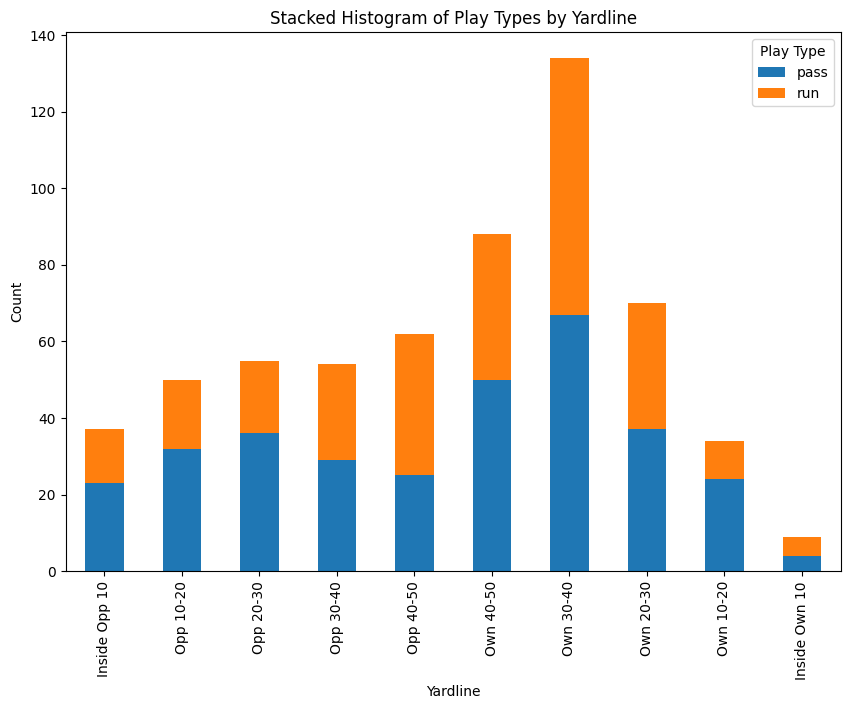

In [28]:
crosstab_first.plot(kind='bar', stacked = True, figsize = (10, 7))
plt.title('Stacked Histogram of Play Types by Yardline')
plt.xlabel('Yardline')
plt.ylabel('Count')
plt.legend(title='Play Type')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [29]:
crosstab_first_normalized = crosstab_first.div(crosstab_first.sum(axis=1), axis=0)
crosstab_first_normalized

play_type,pass,run
yardline_group,,
Inside Opp 10,0.621622,0.378378
Opp 10-20,0.640000,0.360000
Opp 20-30,0.654545,0.345455
Opp 30-40,0.537037,0.462963
Opp 40-50,0.403226,0.596774
Own 40-50,0.568182,0.431818
Own 30-40,0.500000,0.500000
Own 20-30,0.528571,0.471429
Own 10-20,0.705882,0.294118


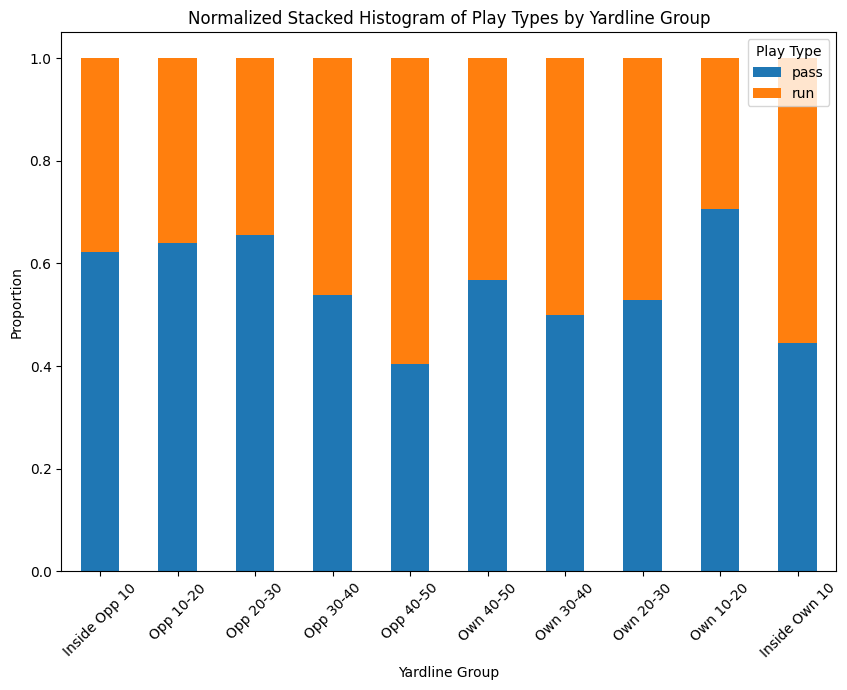

In [31]:
# Plot the stacked histogram using normalized data
crosstab_first_normalized.plot(kind='bar', stacked=True, figsize=(10, 7))

# Add titles and labels
plt.title('Normalized Stacked Histogram of Play Types by Yardline Group')
plt.xlabel('Yardline Group')
plt.ylabel('Proportion')
plt.legend(title='Play Type')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

In [16]:
second_down = df_down_distance[df_down_distance['down'] == 2]
second_down

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
3,67,2,7,run,22,0,15,yes
5,36,2,1,run,0,2,1,yes
7,32,2,8,pass,0,2,-6,no
10,22,2,10,run,0,-3,-13,no
13,5,2,5,run,0,0,-5,no
...,...,...,...,...,...,...,...,...
1775,20,2,10,run,3,0,-7,no
1778,6,2,6,run,0,1,-5,no
1784,72,2,17,pass,9,0,-8,no
1788,3,2,3,run,0,3,0,yes


In [17]:
third_down = df_down_distance[df_down_distance['down'] == 3]
third_down

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
8,30,3,6,run,8,0,2,yes
11,25,3,13,pass,0,6,-7,no
14,5,3,5,run,5,0,0,yes
23,65,3,4,pass,24,0,20,yes
29,13,3,6,run,2,0,-4,no
...,...,...,...,...,...,...,...,...
1773,91,3,16,run,8,0,-8,no
1776,17,3,7,pass,0,7,0,yes
1779,5,3,5,pass,0,0,-5,no
1785,63,3,8,pass,0,0,-8,no


In [18]:
fourth_down = df_down_distance[df_down_distance['down'] == 4]
fourth_down

,yardline_100,down,ydstogo,play_type,receiving_yards,rushing_yards,net_yds,got_first_down
31,11,4,4,run,0,0,-4,no
43,19,4,19,pass,0,0,-19,no
93,74,4,14,run,0,0,-14,no
97,66,4,7,pass,0,0,-7,no
103,12,4,1,pass,0,1,0,yes
...,...,...,...,...,...,...,...,...
1729,14,4,1,pass,0,0,-1,no
1734,68,4,8,pass,0,0,-8,no
1738,43,4,1,run,0,0,-1,no
1770,79,4,19,pass,0,0,-19,no


### Question #3 
---
**Justin Nolan**
- How do different team statistics correlate with winning outcomes in Week 1 games?


### Question #4
---
**Darell Johnson**

- What are the conversion rates for possession downs? What tendencies did you identify?